In [169]:
import torch 
import numpy as np
import ot 
from tqdm import tqdm
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection


torch.set_default_dtype(torch.float64)

# Utils

In [170]:
def torch_divmod(n: torch.Tensor, d: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Equivalent to divmod for tensors. TODO If implemented nicely in pytorch, could submit a PR. 

    parameters:
        n: torch.Tensor, shape [...]
        d: int

    returns:
        tuple of tensors, shape [...]
    """
    return n // d, n % d


def joint_multinomial(distribution: torch.Tensor, num_samples: int, replacement: bool = True) -> torch.Tensor:
    """
    Sample from a joint categorical distribution.

    parameters:
        distribution: torch.Tensor, shape (N, M)
        num_samples: int, number of samples to draw
        replacement: bool, whether to sample with replacement

    returns:
        torch.Tensor, shape (num_samples, 2)
    """
    n, _ = distribution.shape
    res = torch.multinomial(distribution.flatten(), num_samples, replacement=replacement)
    res_i, res_j = torch_divmod(res, n)
    return torch.column_stack([res_i, res_j])

In [171]:
class SDE(ABC):
    """
    Base class for Diagonalizable SDEs. 
    """
    def __init__(self, dim: int):
        self._dim = dim 

    @property
    def dim(self) -> int:
        return self._dim 
    
    @abstractmethod
    def drift(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def diffusion(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def transition(
        self, 
        t0: torch.Tensor, 
        t1: torch.Tensor,
    ) -> torch.Tensor:
        pass

    def _mean(self, t: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Unconditional mean not implemented for this SDE.") 

    @abstractmethod
    def _mean_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _mean_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def mean(
        self, 
        t: torch.Tensor, 
        *,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the mean of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Mean.
        """
        if x0 is not None and x1 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            if t1 is None:
                t1 = t.new_ones(t.shape) # [...]
            return self._mean_with_initial_and_final_condition(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        elif x0 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            return self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        else:
            return self._mean(t)

    def _variance(
        self, 
        t: torch.Tensor, 
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional variance not implemented for this SDE.") 

    @abstractmethod
    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _variance_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def variance(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.
        
        returns: 
            torch.Tensor: [..., D] Variance.
        """
        if t0 is True:
            t0 = t.new_zeros(t.shape) # [...]
        if t1 is True:
            t1 = t.new_ones(t.shape) # [...]
        if t0 is not None and t1 is not None:
            return self._variance_with_initial_and_final_condition(t=t, t0=t0, t1=t1)
        elif t0 is not None:
            return self._variance_with_initial_condition(t=t, t0=t0)
        else:
            return self._variance(t)

    def _covariance(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional covariance not implemented for this SDE.") 

    def _covariance_with_initial_condition(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def _covariance_with_initial_and_final_condition(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
        *, 
        t0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        # This could be implemented already here by conditioning of Gaussian processes, but is not needed for now. 
        raise NotImplementedError("Unconditional covariance not implemented yet. Can be implemented by the Gaussian process conditioning rule.") 

    def covariance(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        if (t0 is True or t0 is not None) and (t1 is True or t1 is not None):
            return self._covariance_with_initial_and_final_condition(s=s, t=t, t0=t0, t1=t1)
        elif (t0 is True or t0 is not None):
            return self._covariance_with_initial_condition(s=s, t=t, t0=t0)
        else: 
            return self._covariance(s=s, t=t)

    @abstractmethod
    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """


class DiagonalizableSDE(SDE):
    @abstractmethod
    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Transforms the points from eigencoordinates to the original coordinates. 

        parameters: 
            x (torch.Tensor): [..., D] Points in eigencoordinates.

        returns: 
            torch.Tensor: [..., D] Points in original coordinates.
        """
        pass

    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """
        if x0 is not None and t0 is None:
            t0 = t.new_zeros(t.shape) # [...]
        if x1 is not None and t1 is None:
            t1 = t.new_ones(t.shape) # [...]

        mean = self.mean(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        # FIXME variance returns negative values
        variance = self.variance(t=t, t0=t0, t1=t1)
        normal = torch.distributions.Normal(loc=mean, scale=variance.sqrt())
        return torch.distributions.Independent(normal, reinterpreted_batch_ndims=1)

    def _covariance_with_initial_condition(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the covariance of the SDE between times s and t conditioned on being at x0 at time t0. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Conditioning times.
        returns: 
            torch.Tensor: [..., D] Diagonal of the (diagonal) covariance matrix.
        """
        r = torch.minimum(s, t)
        return self.transition(t0=r, t1=t) * self.variance(t=r, t0=t0) * self.transition(t0=r, t1=s)


class OUDiagonalizableSDE(DiagonalizableSDE):
    def __init__(self, alpha_diagonal: torch.Tensor, gamma: torch.Tensor):
        """
        Creates the diagonal OU SDE.

        ..math:: 
            dX_t = \alpha X_t dt + \gamma dW_t

        parameters: 
            alpha_diagonal (torch.Tensor): [D] Vector representing the diagonal of the drift matrix alpha.
            gamma (torch.Tensor): [] Scalar diffusion coefficient.
        """
        dim = alpha_diagonal.shape[0]
        super().__init__(dim=dim)
        self.alpha_diagonal = alpha_diagonal
        self.gamma = gamma

    def drift(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the drift of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Drift of the SDE.
        """
        return self.alpha_diagonal * x

    def diffusion(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the diffusion of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.

        returns: 
            torch.Tensor: [] Diffusion of the SDE.
        """
        return self.gamma

    def transition(self, t0: torch.Tensor, t1: torch.Tensor) -> torch.Tensor:
        """
        Returns a vector representing the transition matrix, which is itself a diagonal matrix. 

        parameters: 
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the transition matrix.
        """
        delta = t1 - t0 # [...]
        return torch.exp(torch.einsum("d, ... -> ...d", self.alpha_diagonal, delta))

    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero-variance at time t0.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the variance of the SDE.
        """
        variance_if_alpha_zero = torch.unsqueeze(self.gamma.square() * (t - t0), -1) # [..., 1]
        variance_if_alpha_nonzero = (
            self.gamma.square() * (self.transition(t0=t0, t1=t).square() - 1) / (2 * self.alpha_diagonal)
        ) # [..., D]
        return torch.where(self.alpha_diagonal == 0, variance_if_alpha_zero, variance_if_alpha_nonzero) # [..., D]

    def _variance_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None, 
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero variance at time t0 and t1.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.
            t1 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the conditional variance of the SDE.
        """
        sigmatt = self.variance(t=t, t0=t0)
        sigmat1t = self.covariance(s=t, t=t1, t0=t0) # FIXME this should be symmetric but is antisymmetric
        sigmat1t1 = self.variance(t=t1, t0=t0)

        return sigmatt - sigmat1t.square() / sigmat1t1

    def _mean_with_initial_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0.
        
        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Mean of the SDE.
        """
        return self.transition(t0=t0, t1=t) * x0 # [..., D] * [..., D] -> [..., D]

    def _mean_with_initial_and_final_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None, t1: torch.Tensor | None = None, x1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0 and x1 at time t1. 

        parameters: 
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Conditional mean of the SDE.
        """
        m_t = self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        m_t1 = self._mean_with_initial_condition(t=t1, t0=t0, x0=x0)
        sigma_t1t = self.covariance(s=t, t=t1, t0=t0) # FIXME This should be symmetric but is antisymmetric
        sigma_t1t1 = self.variance(t=t1, t0=t0)
        return m_t + sigma_t1t / sigma_t1t1 * (x1 - m_t1)
     

class HeatBMTSDE(OUDiagonalizableSDE):
    def __init__(self, L: torch.Tensor, c: torch.Tensor, sigma: torch.Tensor):
        """
        Creates the heat BM SDE:

        ..math:: 
            dX_t = -cLX_t dt + \sigma dW_t

        parameters: 
            L (torch.Tensor): [D, D] Matrix representing the Laplacian.
            c (torch.Tensor): [] Scalar.
            sigma (torch.Tensor): [] Scalar diffusion coefficient.
        """
        L = torch.as_tensor(L, dtype=torch.float64)
        c = torch.as_tensor(c, dtype=torch.float64)
        sigma = torch.as_tensor(sigma, dtype=torch.float64)
        eigenvalues, eigenvectors = torch.linalg.eigh(L)
        alpha_diagonal = -c * eigenvalues
        gamma = sigma
        
        super().__init__(alpha_diagonal=alpha_diagonal, gamma=gamma)
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the inverse transform of the SDE. 

        parameters: 
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Inverse transform of the SDE.
        """
        return torch.einsum("ij, ...j -> ...i", self.eigenvectors, x) # [D, D] * [..., D] -> [..., D]


def bridge_control(
    sde: SDE, 
    t: torch.Tensor, 
    x: torch.Tensor, 
    *, 
    t1: torch.Tensor | None = None, 
    x1: torch.Tensor,
) -> torch.Tensor:
    """
    Returns the control for the bridge of the SDE at time t and position x needed to reach x1 at time t1. 

    parameters: 
        sde (SDE): The SDE to create the bridge control for.
        t (torch.Tensor): [...] Current times.
        x (torch.Tensor): [..., D] Current values.
        t1 (torch.Tensor): [...] Target times.
        x1 (torch.Tensor): [..., D] Target values.

    returns: 
        torch.Tensor: [..., D] Control.
    """
    if t1 is None:
        t1 = x1.new_ones(x1.shape[:-1]) # [...]
    score = sde.transition(t0=t, t1=t1) * (x1 - sde.mean(t0=t, x0=x, t=t1)) / sde.variance(t0=t, t=t1)
    return sde.diffusion(t=t).square() * score


class Control:
    @abstractmethod
    def control(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        pass 

    def __call__(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the control at time t and position x. 

        parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        returns: 
            torch.Tensor: [..., D] Control.
        """
        return self.control(t=t, x=x, **kwargs)


class ZeroControl(Control):
    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x.new_zeros(x.shape) # [..., D]


class BridgeControl(Control):
    def __init__(self, sde: SDE, x1: torch.Tensor, t1: torch.Tensor | None = None): 
        """
        Creates the bridge control for the SDE conditioned on being at x1 at time t1. 

        parameters: 
            sde (SDE): The SDE to create the bridge control for.
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.
        """
        self.sde = sde
        self._x1 = None
        self._t1 = None
        self.condition(x1=x1, t1=t1)

    def condition(self, x1: torch.Tensor, t1: torch.Tensor | None = None) -> "BridgeControl":
        """
        Conditions the bridge on being at x1 at time t1. 

        parameters: 
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            BridgeControl: The bridge control.
        """
        if t1 is None:
            t1 = x1.new_ones(x1.shape[:-1]) # [...]
        self._x1 = x1
        self._t1 = t1
        return self

    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the control for the bridge at time t and position x. 

        parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        returns: 
            torch.Tensor: [..., D] Control.
        """
        return bridge_control(sde=self.sde, t=t, x=x, t1=self._t1, x1=self._x1)


class ModelControl(Control):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    def __call__(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.model(t, x)


In [172]:
class EntropicOTSolver:
    def __init__(self, sde: SDE, normalize_variance: bool = True):
        self.sde = sde 
        # TODO might need to put the variance on the right device, so maybe SDE should have a device attribute?
        variance = self.sde.variance(t0=torch.tensor(0.0), t=torch.tensor(1.0))

        if normalize_variance:
            self._epsilon = torch.prod(variance).pow(1.0 / self.sde.dim)
            self.normed_stddev = torch.sqrt(variance / self.epsilon) # [..., D]
        else:
            self._epsilon = 1.0
            self.normed_stddev = torch.sqrt(variance) # [..., D]

    @property
    def epsilon(self) -> torch.Tensor:
        """
        Returns the epsilon parameter for the entropic OT.

        .. math::
           \min_{\pi \in \Pi(\mu, \nu)} \mathbb{E}_{(x, y) \sim \pi}[c(x, y)] + \epsilon H(\pi)

        returns: 
            torch.Tensor: [..., D] Epsilon parameter. 
        """
        return self._epsilon

    def cost(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost between x0 and x1.

        parameters:
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [...] Optimal transport cost.
        """

        t0 = x0.new_zeros(x0.shape[:-1])
        t1 = x1.new_ones(x1.shape[:-1])
        z = (x1 - self.sde.mean(t0=t0, x0=x0, t=t1)) / self.normed_stddev # ([..., D] - [..., D]) / [D] -> [..., D]
        return torch.linalg.vector_norm(z, ord=2, dim=-1) # [..., D] -> [...]

    def cost_matrix(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost matrix between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [..., N, D] Initial value.
            x1 (torch.Tensor): [..., M, D] Target value.

        returns: 
            torch.Tensor: [..., N, M] Cost matrix.
        """
        assert x0.ndim >= 2, "x0 must have at least 2 dimensions"
        assert x1.ndim >= 2, "x1 must have at least 2 dimensions"

        # Expand x0 and x1 for broadcasting
        # x0_expanded: [..., N, 1, D]
        # x1_expanded: [..., 1, M, D]
        x0_expanded = x0.unsqueeze(-2)  # [..., N, 1, D]
        x1_expanded = x1.unsqueeze(-3)  # [..., 1, M, D]

        # Compute cost for each pair (n, m)
        # Use the same cost as in self.cost, but vectorized
        t0 = x0.new_zeros(x0.shape[:-2] + (x0.shape[-2], 1))  # [..., N, 1]
        t1 = x1.new_ones(x0.shape[:-2] + (1, x1.shape[-2]))   # [..., 1, M]
        # mean: [..., N, 1, D]
        mean = self.sde.mean(t0=t0, x0=x0_expanded, t=t1)
        # normed_variance: [D]
        z = (x1_expanded - mean) / self.normed_stddev  # ([..., 1, M, D] - [..., N, 1, D]) / [D] -> [..., N, M, D]
        cost = torch.linalg.vector_norm(z, ord=2, dim=-1)  # [..., N, M]
        return cost
        
    def solve(
        self, 
        x0: torch.Tensor, 
        x1: torch.Tensor, 
        method: str = "sinkhorn",
        num_iter_max: int = 1000,
        stop_threshold: float = 1e-9,
        verbose: bool = False,
        log: bool = False,
        warn: bool = True,
    ) -> torch.Tensor:
        """
        Returns the optimal transport plan between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [N, D] Initial value.
            x1 (torch.Tensor): [M, D] Target value.

        returns: 
            torch.Tensor: [N, M] Optimal transport plan.
        """
        assert x0.ndim == 2, "x0 must have 2 dimensions"
        assert x1.ndim == 2, "x1 must have 2 dimensions"

        cost_matrix = self.cost_matrix(x0, x1)
        px0 = x0.new_ones(x0.shape[0]) / x0.shape[0]
        px1 = x1.new_ones(x1.shape[0]) / x1.shape[0]
        return ot.sinkhorn(
            a=px0, 
            b=px1, 
            M=cost_matrix, 
            reg=self.epsilon, 
            method=method,
            num_iter_max=num_iter_max, 
            stop_threshold=stop_threshold, 
            verbose=verbose, 
            log=log, 
            warn=warn
        )


class UniformTimesteps:
    def __init__(self, n: int):
        assert n > 1, "Number of timesteps must be greater than 1"
        self.n = n
        self.t = torch.linspace(0, 1, n + 1, dtype=torch.float64)
        self.dt = torch.full((n, ), 1.0 / n, dtype=torch.float64)


class EulerMaruyamaSolver(torch.nn.Module):
    def __init__(self, sde: SDE, n: int, timesteps: str = "uniform"):
        # TODO Consider whether to move the SDE into sample_path.
        super().__init__()
        self.sde = sde

        if timesteps == "uniform":
            self.timesteps = UniformTimesteps(n)
        else:
            raise ValueError(f"Invalid timesteps: {timesteps}")

    def dx(self, dt: torch.Tensor, t: torch.Tensor, x: torch.Tensor, *, control: Control) -> torch.Tensor:
        """
        Returns the change in the SDE. 

        parameters: 
            dt (torch.Tensor): [] Duration of the timestep.
            t (torch.Tensor): [] Time.
            x (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Change in the SDE.
        """
        t = t.expand(x.shape[:-1])
        drift = self.sde.drift(t=t, x=x) + control(t=t, x=x)
        diffusion = self.sde.diffusion(t=t, x=x)
        return drift * dt + diffusion * torch.sqrt(dt) * torch.randn_like(x)

    def sample_path(self, x0: torch.Tensor, *, control: Control | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples a path from the SDE.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            tuple[torch.Tensor, torch.Tensor]: [..., T, D] Path and [T] Time.
        """

        if control is None:
            control = ZeroControl()

        ts = self.timesteps.t
        dts = self.timesteps.dt

        x = x0
        xs = [x]
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt=dt, t=t, x=x, control=control)
            xs.append(x)
        return torch.stack(xs, dim=-2), ts

# Linear diffusion bridges

In [173]:
dim = 2
L = torch.eye(dim)
c = 4.0
sigma = 1.0
n = 1000

sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
sde_solver = EulerMaruyamaSolver(sde=sde, n=n)

delta_x = torch.tensor([3.0, 0.0])
x0 = torch.tensor([-1.0, -1.0]) + delta_x
x1 = torch.tensor([1.0, 1.0]) + delta_x

# Sample 100 paths from x0 to x1
x0s = x0.expand(100, 2)
x1s = x1.expand(100, 2)
control = BridgeControl(sde=sde, x1=x1s)
xts, ts = sde_solver.sample_path(x0s, control=control)
xts = sde.inverse_transform(xts)


xmids = sde.marginal_distribution(t=torch.tensor(0.7), x0=x0, x1=x1).sample((100,))

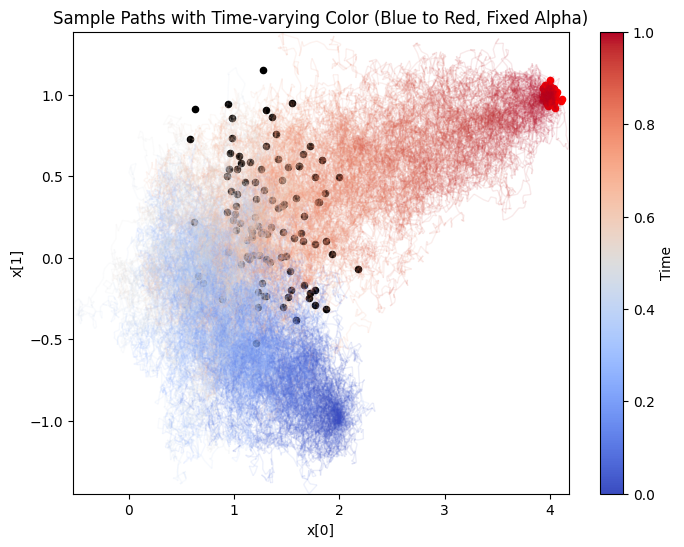

In [180]:
# Assume xts shape: [N, T, D] or [T, D] if single batch
xts_np = xts.detach().cpu().numpy()
ts_np = ts.detach().cpu().numpy()

# Ensure shape is [N, T, D]
if xts_np.ndim == 2:
    xts_np = xts_np[None, ...]  # [1, T, D]

N, T, D = xts_np.shape
assert D == 2, "D must be 2 for 2D plotting"

# Prepare segments for LineCollection: each path is (T, 2), segments are (T-1, 2, 2)
segments = []
colors = []
norm = plt.Normalize(ts_np.min(), ts_np.max())
# Use a blue-to-red colormap
cmap = plt.get_cmap('coolwarm')  # blue (low) to red (high)

# Use a single alpha value for all lines
global_alpha = 0.1

for i in range(N):
    points = xts_np[i, :, :2]
    segs = np.stack([points[:-1], points[1:]], axis=1)  # (T-1, 2, 2)
    segments.append(segs)
    # Color for each segment (time-varying colormap, fixed alpha)
    t_mid = (ts_np[:-1] + ts_np[1:]) / 2
    seg_colors = cmap(norm(t_mid))
    seg_colors[:, -1] = global_alpha  # Set the same alpha for all segments
    colors.append(seg_colors)

# Concatenate all segments and colors
all_segments = np.concatenate(segments, axis=0)
all_colors = np.concatenate(colors, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(all_segments, colors=all_colors, linewidths=1)
ax.add_collection(lc)

# Add scatterplot of xmids, black markers
xmids_np = xmids.detach().cpu().numpy()
x1s_np = xts_np[..., -1, :]
ax.scatter(xmids_np[:, 0], xmids_np[:, 1], color='k', marker='o', s=20, label='xmids')
ax.scatter(x1s_np[:, 0], x1s_np[:, 1], color='r', marker='o', s=20, label='x1s')

# Set axis limits
all_x = xts_np[..., 0].ravel()
all_y = xts_np[..., 1].ravel()
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Sample Paths with Time-varying Color (Blue to Red, Fixed Alpha)')

# Colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()


# Optimal Transport Cost

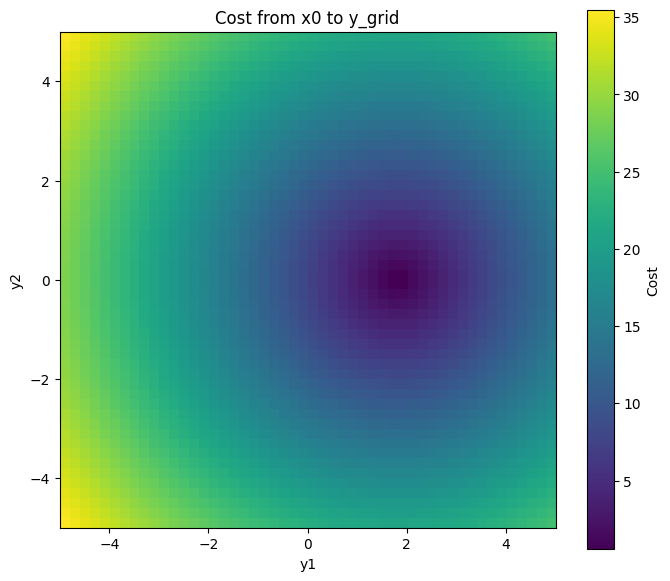

In [80]:
# Solve entropic OT problem between a centred Gaussian and a mixture of three Gaussians
dim = 2
L = torch.eye(dim)
c = 0.5
sigma = 0.3

sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=False)


x0 = torch.tensor([3.0, 0.0])
# Create a grid of y points and evaluate the cost from x0 to them using cost_matrix

# Define grid limits and resolution
y_min, y_max, n_grid = -5.0, 5.0, 50
y1 = torch.linspace(y_min, y_max, n_grid)
y2 = torch.linspace(y_min, y_max, n_grid)
y1g, y2g = torch.meshgrid(y1, y2, indexing='xy')
y_grid = torch.stack([y1g, y2g], dim=-1)

# Evaluate cost from x0 to each y in the grid using cost_matrix
costs = ot_solver.cost(x0.expand_as(y_grid), y_grid)


# Plot the cost as a heatmap
plt.figure(figsize=(8, 7))
plt.imshow(costs, extent=[y_min, y_max, y_min, y_max], cmap='viridis')
plt.colorbar(label='Cost')
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Cost from x0 to y_grid')
plt.show()

# Optimal transfer plan and the induced linear flow

In [81]:
delta_mu = torch.tensor([3.0, 0.0])

mu0, sigma0 = torch.zeros(2) + delta_mu, torch.eye(2) * 0.3
R0 = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)

r = 2.0
mu11, sigma11 = torch.tensor([0.0, 2.0]) * r + delta_mu, torch.eye(2) * 0.1
mu12, sigma12 = torch.tensor([-1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
mu13, sigma13 = torch.tensor([1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
component_distribution = torch.distributions.MultivariateNormal(
    loc=torch.stack([mu11, mu12, mu13], dim=0), 
    covariance_matrix=torch.stack([sigma11, sigma12, sigma13], dim=0)
)
mixture_distribution = torch.distributions.Categorical(probs=torch.tensor([1/3, 1/3, 1/3]))
R1 = torch.distributions.MixtureSameFamily(
    mixture_distribution=mixture_distribution, 
    component_distribution=component_distribution
)

n_samples = 100
x0 = R0.sample((n_samples,))
x1 = R1.sample((n_samples,))

ot_plan = ot_solver.solve(x0, x1)

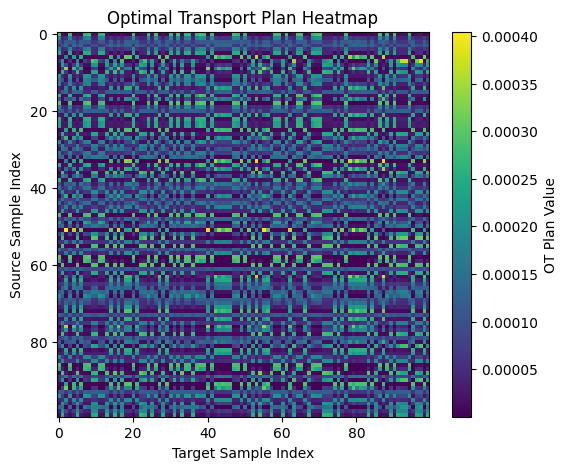

In [82]:
plt.figure(figsize=(6, 5))
plt.imshow(ot_plan, aspect='auto', cmap='viridis')
plt.colorbar(label='OT Plan Value')
plt.title('Optimal Transport Plan Heatmap')
plt.xlabel('Target Sample Index')
plt.ylabel('Source Sample Index')
plt.show()

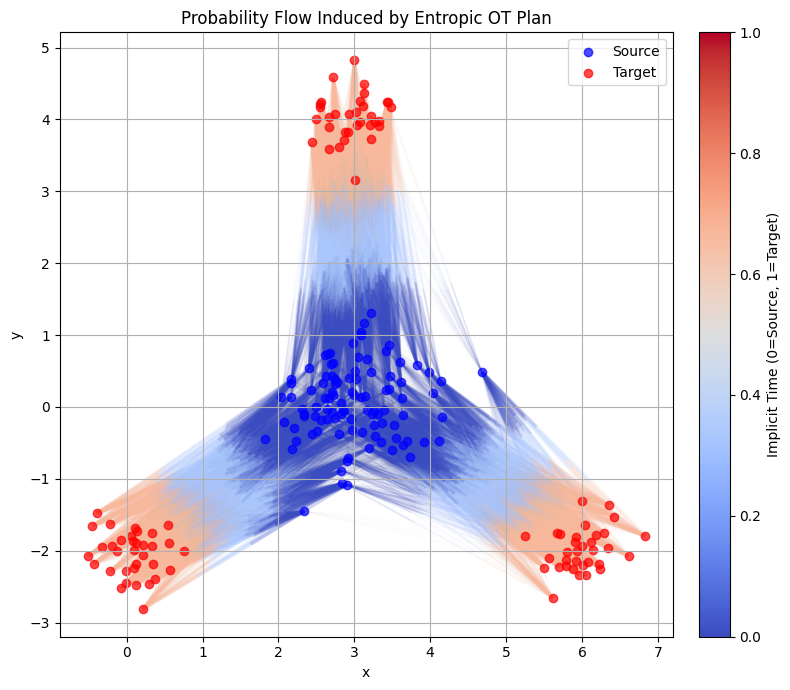

In [83]:
# Ensure x0, x1, and ot_plan are on CPU and convert to numpy arrays
x0_np = x0.cpu().numpy() if hasattr(x0, "cpu") else x0.numpy()
x1_np = x1.cpu().numpy() if hasattr(x1, "cpu") else x1.numpy()
ot_plan_np = ot_plan.cpu().numpy() if hasattr(ot_plan, "cpu") else ot_plan.numpy()

# (Assume x0_np, x1_np, ot_plan_np are already CPU NumPy arrays.)
n = x0_np.shape[0]

plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.scatter(x0_np[:, 0], x0_np[:, 1],
           color='blue', label='Source', alpha=0.7)
ax.scatter(x1_np[:, 0], x1_np[:, 1],
           color='red',  label='Target', alpha=0.7)

# parameters
max_plan = ot_plan_np.max()
threshold = 0.01 * max_plan

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=1)

segments = []
colors = []
widths = []

# how many sub‐segments per arrow
n_sub = 3

for i in range(n):
    for j in range(n):
        w = ot_plan_np[i, j]
        if w <= threshold:
            continue

        start = x0_np[i]
        end = x1_np[j]
        # generate equally‐spaced points along the line
        pts = np.linspace(start, end, n_sub + 1)

        # line thickness & overall alpha from flow magnitude
        flow = w / max_plan
        lw = 0.5 + 2.5 * flow
        alpha = flow * 0.3

        # build each tiny segment
        for k in range(n_sub):
            seg_t = [pts[k], pts[k + 1]]
            t = k / n_sub  # 0 at source, 1 at target
            # pick color from cmap and inject our α
            r, g, b, _ = cmap(norm(t))
            colors.append((r, g, b, alpha))
            widths.append(lw)
            segments.append(seg_t)

# assemble the LineCollection
lc = LineCollection(segments,
                    colors=colors,
                    linewidths=widths,
                    zorder=0)
ax.add_collection(lc)

# add colorbar for “time” scale
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(0, 1, 100))   # dummy array
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Implicit Time (0=Source, 1=Target)')

ax.set(title='Probability Flow Induced by Entropic OT Plan',
       xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Conditional OT Flow Matching Loss

In [84]:
class UniformTimeSampler:
    def sample(self, shape: torch.Size) -> torch.Tensor:
        return torch.rand(shape)


class MatchingDataset(torch.utils.data.Dataset):
    def __init__(self, x0: torch.Tensor, x1: torch.Tensor, time_sampler: UniformTimeSampler | None = None):
        super().__init__()
        self.x0 = x0
        self.x1 = x1
        self.time_sampler = time_sampler or UniformTimeSampler()
    
    def __getitem__(self, idx: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        returns:
            t: torch.Tensor, shape [...]
            x0: torch.Tensor, shape [..., D]
            x1: torch.Tensor, shape [..., D]
        """
        x0_idx, x1_idx = torch.unbind(idx, dim=-1)
        t = self.time_sampler.sample(x0_idx.shape)
        return t, self.x0[x0_idx], self.x1[x1_idx]
    
    def __len__(self) -> int:
        raise NotImplementedError("Length of MatchingDataset is not defined.")
        

class OTBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: MatchingDataset, ot_solver: EntropicOTSolver, batch_size: int, num_samples: int):
        super().__init__()
        self.dataset = dataset
        self.joint_distribution = ot_solver.solve(dataset.x0, dataset.x1)
        self.batch_size = batch_size
        self.num_samples = num_samples

    def __iter__(self):
        for _ in range(len(self)):
            yield joint_multinomial(self.joint_distribution, self.batch_size)

    def __len__(self) -> int:
        return self.num_samples // self.batch_size


class MatchingDataLoader:
    def __init__(self, dataset: MatchingDataset, batch_sampler: OTBatchSampler):
        self.dataset = dataset
        self.batch_sampler = batch_sampler

    def __iter__(self):
        for batch in self.batch_sampler:
            yield self.dataset[batch]

    def __len__(self) -> int:
        return len(self.batch_sampler)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 10):
        super().__init__()
        self.dim = dim
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, dim),
        )

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return self.nn(t.unsqueeze(-1))


class ResidualMLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Input layer: now takes both t and x as input
        self.input_layer = torch.nn.Linear(1 + dim, hidden_dim)

        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, dim)

        self.activation = torch.nn.ReLU()

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Concatenate t and x along the last dimension
        t = t.unsqueeze(-1) if t.ndim == x.ndim - 1 else t
        inp = torch.cat([t, x], dim=-1)
        out = self.input_layer(inp)
        for layer in self.hidden_layers:
            residual = out
            out = self.activation(out)
            out = layer(out)
            out = out + residual  # Residual connection
        out = self.activation(out)
        out = self.output_layer(out)
        return out

In [185]:
delta_mu = torch.tensor([3.0, 0.0])

mu0, sigma0 = torch.zeros(2) + delta_mu, torch.eye(2) * 0.3
R0 = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)

r = 3.0
mu11, sigma11 = torch.tensor([0.0, 2.0]) * r + delta_mu, torch.eye(2) * 0.1
mu12, sigma12 = torch.tensor([-1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
mu13, sigma13 = torch.tensor([1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
component_distribution = torch.distributions.MultivariateNormal(
    loc=torch.stack([mu11, mu12, mu13], dim=0), 
    covariance_matrix=torch.stack([sigma11, sigma12, sigma13], dim=0)
)
mixture_distribution = torch.distributions.Categorical(probs=torch.tensor([1/3, 1/3, 1/3]))
R1 = torch.distributions.MixtureSameFamily(
    mixture_distribution=mixture_distribution, 
    component_distribution=component_distribution
)

n_samples = 1000
x0 = R0.sample((n_samples,))
x1 = R1.sample((n_samples,))

sigma = 0.5
c = 0.0
sde = HeatBMTSDE(L=torch.eye(2), c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=True)

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s, avg_loss=2.2703] 


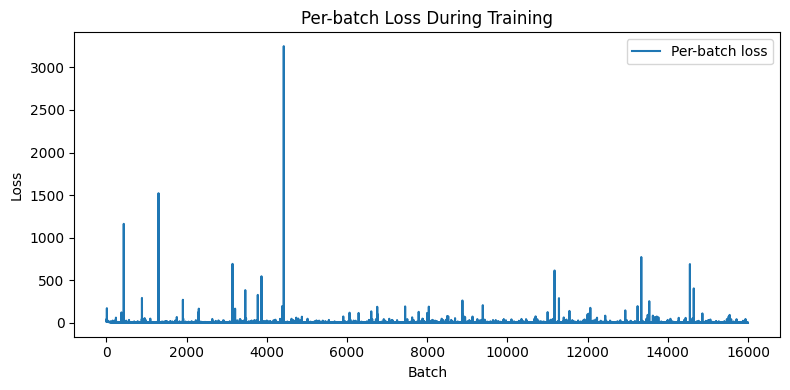

In [192]:
dataset = MatchingDataset(x0, x1)
batch_sampler = OTBatchSampler(dataset, ot_solver, batch_size=64, num_samples=1024)
data_loader = MatchingDataLoader(dataset, batch_sampler=batch_sampler)

# model = MLP(dim=2)
model = ResidualMLP(dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
objective = torch.nn.MSELoss()
# objective = ConditionalOTFlowMatchingLoss(sde)

per_batch_losses = []

with tqdm(range(1000), desc="Epochs") as pbar:
    for epoch in pbar:
        epoch_loss = 0.0
        num_batches = 0
        for batch_t, batch_x0, batch_x1 in data_loader:
            # sample xt, compute targets and predictions
            batch_x = sde.marginal_distribution(t=batch_t, x0=batch_x0, x1=batch_x1).sample()
            ut = bridge_control(sde=sde, t=batch_t, x=batch_x, x1=batch_x1)
            ut_preds = model(batch_t, batch_x)

            # Generic loss computation and backprop
            loss = objective(ut, ut_preds)
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            per_batch_losses.append(batch_loss)
            epoch_loss += batch_loss
            num_batches += 1
            optimizer.zero_grad()
        avg_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
        pbar.set_postfix({"avg_loss": f"{avg_loss:.4f}"})

# Plot per-batch loss after training
plt.figure(figsize=(8, 4))
plt.plot(per_batch_losses, label="Per-batch loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Per-batch Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

In [193]:
with torch.no_grad():
    model_control = ModelControl(model=model)
    sde_solver = EulerMaruyamaSolver(sde=sde, n=1000)
    x0s_test = R0.sample((1000,))
    x1s_test = R1.sample((1000,))

    xts, ts = sde_solver.sample_path(x0s_test, control=model_control)
    xts = sde.inverse_transform(xts)

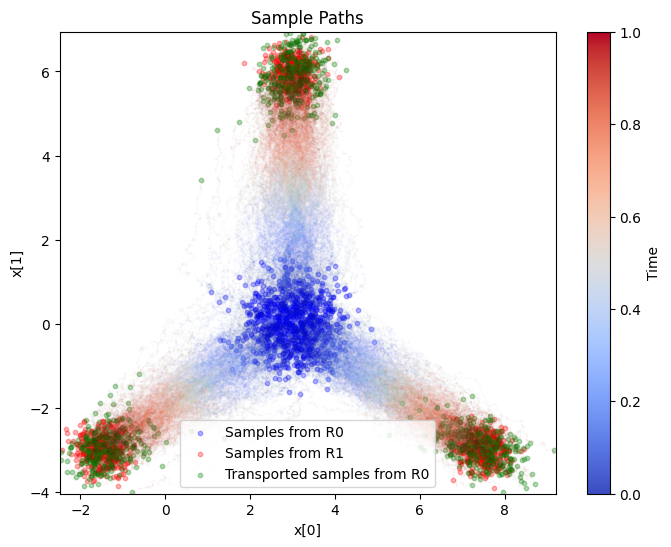

In [195]:
# Assume xts shape: [N, T, D] or [T, D] if single batch
xts_np = xts.detach().cpu().numpy()
ts_np = ts.detach().cpu().numpy()

# Ensure shape is [N, T, D]
if xts_np.ndim == 2:
    xts_np = xts_np[None, ...]  # [1, T, D]

N, T, D = xts_np.shape
assert D == 2, "D must be 2 for 2D plotting"

# Prepare segments for LineCollection: each path is (T, 2), segments are (T-1, 2, 2)
segments = []
colors = []
norm = plt.Normalize(ts_np.min(), ts_np.max())
# Use a blue-to-red colormap
cmap = plt.get_cmap('coolwarm')  # blue (low) to red (high)

# Use a single alpha value for all lines
global_alpha = 0.02

for i in range(N):
    points = xts_np[i, :, :2]
    segs = np.stack([points[:-1], points[1:]], axis=1)  # (T-1, 2, 2)
    segments.append(segs)
    # Color for each segment (time-varying colormap, fixed alpha)
    t_mid = (ts_np[:-1] + ts_np[1:]) / 2
    seg_colors = cmap(norm(t_mid))
    seg_colors[:, -1] = global_alpha  # Set the same alpha for all segments
    colors.append(seg_colors)

# Concatenate all segments and colors
all_segments = np.concatenate(segments, axis=0)
all_colors = np.concatenate(colors, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(all_segments, colors=all_colors, linewidths=1)
ax.add_collection(lc)

# Add scatterplot of xmids, black markers
x0s_test_np = x0s_test.detach().cpu().numpy()
x1s_test_np = x1s_test.detach().cpu().numpy()
x1s_pred_np = xts_np[:, -1]
ax.scatter(x0s_test_np[:, 0], x0s_test_np[:, 1], color='blue', marker='o', s=10, alpha=0.3, label='Samples from R0')
ax.scatter(x1s_test_np[:, 0], x1s_test_np[:, 1], color='red', marker='o', s=10, alpha=0.3, label='Samples from R1')
ax.scatter(x1s_pred_np[:, 0], x1s_pred_np[:, 1], color='green', marker='o', s=10, alpha=0.3, label='Transported samples from R0')
ax.legend()


# Set axis limits
all_x = xts_np[..., 0].ravel()
all_y = xts_np[..., 1].ravel()
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Sample Paths')

# Colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()


# IDEAS
- Maybe instead of learning the control field, we learn control field over diffusion squared. This could make the problem a little easier when diffusion is non-constant